# Covid19 Forecasting with ARIMA Models

<br>

ARIMA model, short for "AutoRegressive Integrated Moving Average", is a very frequently used forecasting algorithm for time series problems and is usually utilized as a forecasting benchmark. The algorithm of ARIMA is based on the idea that the information in the past values of the time series can alone be used to predict the future values. An ARIMA model is characterized by 3 terms: Auto-regression model, Moving average model, and the number of differencing required to make the time series stationary. When the time series you are forecasting on has seasonal patterns, you should add a seasonal terms and it becomes SARIMA Model.

<br>

**Situations where ARIMA would work better:**
* When you have relatively longer time series of values that have less volatility. Because ARIMA models only predicts by analyzing the patterns of the historical time series. shorter historical time series and volatile time series values would make ARIMA affected by outliers.

**Situations where ARIMA is not a very good choice:**
* When the variation of your time series majorly depends on independent features other than the patterns in the historical time series data. The COVID19 forecasting is one of them, since the number of cases over time heavily depends on the culture, lockdown policies or the density of the area. In this case, ARIMA will not be able to take them into account in order to forecast accurately.

#### This Notebook will showcase the following techniques:<br>
<br>
1. EDA - Understand the time series patterns


- How to explore the basic patterns (seasonal or trends) of the COVID19 cases and deaths

<br>

2. Construct the (S)ARIMA Models and Forecast


- How to tune the hyperparameters of (S)ARIMA Model
- How to evaluate the selected (S)ARIMA results

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
import itertools
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

In [3]:
data = pd.read_csv('train.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date',inplace=True)
data.head()

C:\Users\olivi\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Id,County,Province_State,Country_Region,Population,Weight,Target,TargetValue
Date,,,,,,,,
2020-01-23,1,NaN,NaN,Afghanistan,27657145,0.058359,ConfirmedCases,0
2020-01-23,2,NaN,NaN,Afghanistan,27657145,0.583587,Fatalities,0
2020-01-24,3,NaN,NaN,Afghanistan,27657145,0.058359,ConfirmedCases,0
2020-01-24,4,NaN,NaN,Afghanistan,27657145,0.583587,Fatalities,0
2020-01-25,5,NaN,NaN,Afghanistan,27657145,0.058359,ConfirmedCases,0


In [4]:
cases_us = data[(data['Target'] == 'ConfirmedCases') & (data['Country_Region'] == 'US')]
deaths_us = data[(data['Target'] == 'Fatalities') & (data['Country_Region'] == 'US')]
cases_us.head()

,Id,County,Province_State,Country_Region,Population,Weight,Target,TargetValue
Date,,,,,,,,
2020-01-23,67761,Autauga,Alabama,US,55869,0.091485,ConfirmedCases,0
2020-01-24,67763,Autauga,Alabama,US,55869,0.091485,ConfirmedCases,0
2020-01-25,67765,Autauga,Alabama,US,55869,0.091485,ConfirmedCases,0
2020-01-26,67767,Autauga,Alabama,US,55869,0.091485,ConfirmedCases,0
2020-01-27,67769,Autauga,Alabama,US,55869,0.091485,ConfirmedCases,0


In [5]:
# Inspect the TaretValues in the data
print('There are {} records that contains negative value of cases.'
      .format(cases_us[cases_us['TargetValue']<0].count()['TargetValue']))
# Replace them by 0, which means that they wont be counted into the final aggregation
cases_us = cases_us[~cases_us['TargetValue']<0]

There are 3800 records that contains negative value of cases.


In [6]:
# Inspect the TaretValues in the data
print('There are {} records that contains negative value of deaths.'
      .format(deaths_us[deaths_us['TargetValue']<0].count()['TargetValue']))
# Replace them by 0, which means that they wont be counted into the final aggregation
deaths_us = deaths_us[~deaths_us['TargetValue']<0]

There are 700 records that contains negative value of deaths.


In [5]:
# two time series for the cases and deaths in the US
cases_us = cases_us.groupby(level = 'Date')['TargetValue'].sum()
deaths_us= deaths_us.groupby(level = 'Date')['TargetValue'].sum()
df = cases_us.to_frame()
df = df.rename(columns = {'TargetValue': 'Cases'})
df['Deaths'] = deaths_us

In [6]:
# We will get rid of the days when the US have less than 10 cases and deaths each day
# So the forecasting of the later days would be less affected by values on those days
df =df[(df['Cases']>10)&(df['Deaths']>10)]

In [7]:
df.shape

(93, 2)

# EDA - Understand the time series patterns

------
## 1. Visualize data
------

* Visualize data
* Decomposition 

I will first compute the moving average of the time series, the average of N given time steps. It will smooth the data allowing the viewer to infer some visible patterns or trends.

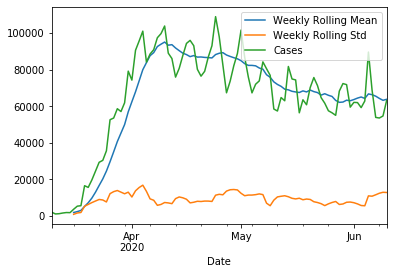

In [32]:
df['Cases'].rolling(7).mean().plot(label='Weekly Rolling Mean')
df['Cases'].rolling(7).std().plot(label='Weekly Rolling Std')
df['Cases'].plot()
plt.legend()
df['cases_4_rolling'] = df['Cases'].rolling(4).mean().dropna()

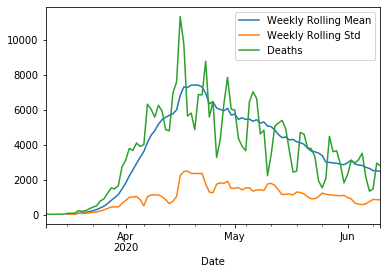

In [33]:
df['Deaths'].rolling(7).mean().plot(label='Weekly Rolling Mean')
df['Deaths'].rolling(7).std().plot(label='Weekly Rolling Std')
df['Deaths'].plot()
plt.legend()
df['deaths_4_rolling'] = df['Deaths'].rolling(4).mean().dropna()

In these two plots, we can clearly spot some regular patterns. Both time series of cases and deaths grew exponentially before Mid-April, then going down gradually. Let's use the decomposition function to see if there is any seasonal trend.

**Decomposition**

C:\Users\olivi\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: the 'freq' keyword is deprecated, use 'period' instead
  


<Figure size 432x288 with 0 Axes>

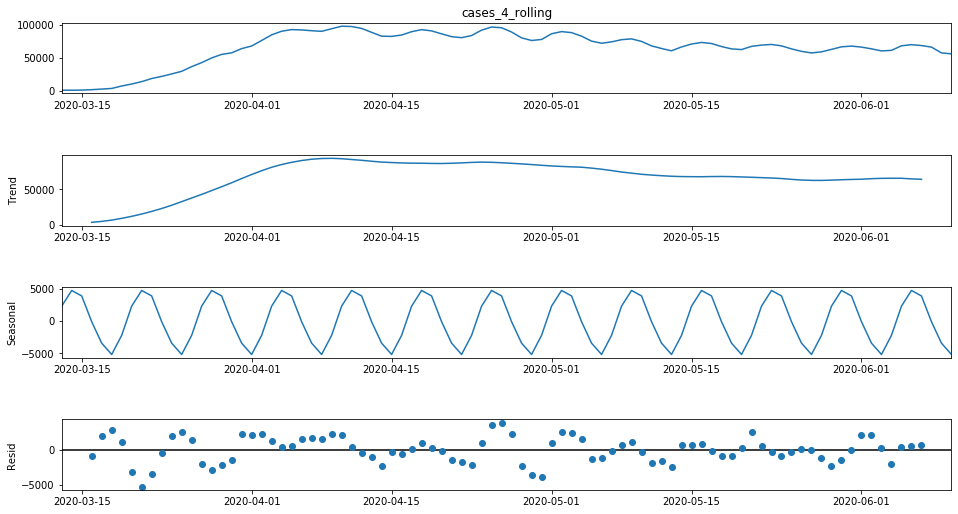

In [34]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df['cases_4_rolling'].dropna(), freq=7)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

C:\Users\olivi\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: the 'freq' keyword is deprecated, use 'period' instead
  


<Figure size 432x288 with 0 Axes>

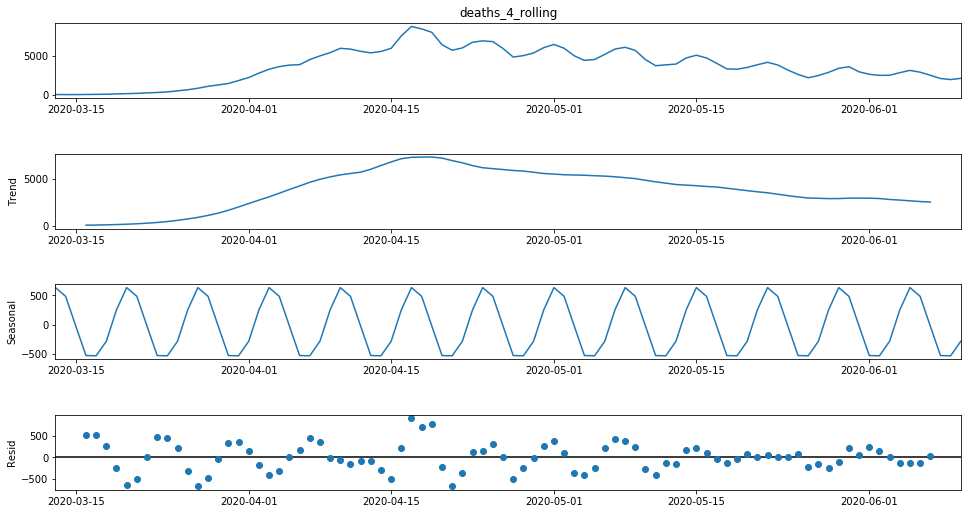

In [35]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df['deaths_4_rolling'].dropna(), freq=7)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

It is pretty obvious that these two time series of the number of cases and deaths in the US both have weekly patterns. And the trend starts from exponentially growing before around April 15 and then gradually going down, which means that both time series are not stationary.

-------
## 2. Make the time series data stationary
-------

For the puspose of finding the relationship between the time series and itself lagging N time steps at the next phase, we need the mean, correlation and covariance between all the time steps to be independent from the time. <br>
* Test for stationarity
* make the time series stationary (using differencing) - meaning that the mean, variance, and covariance of the series should not be a function of time.


**Test for stationarity**

In [36]:
# Store in a function for later use!
def adf_check(time_series):
    """
    Pass in a time series, returns ADF report
    """
    result = adfuller(time_series)
    print('Augmented Dickey-Fuller Test:')
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']

    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
        

In [37]:
adf_check(df['cases_4_rolling'].dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -3.373530972289839
p-value : 0.011894981844721807
#Lags Used : 8
Number of Observations Used : 81
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


In [38]:
adf_check(df['deaths_4_rolling'].dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -2.3768553275798885
p-value : 0.14837565019589743
#Lags Used : 9
Number of Observations Used : 80
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


**Make the death time series stationary**

In [39]:
# First difference
df['Death first difference'] = df['deaths_4_rolling'] - df['deaths_4_rolling'].shift(1)
adf_check(df['Death first difference'].dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -1.6908730073643965
p-value : 0.4358210071025587
#Lags Used : 8
Number of Observations Used : 80
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [40]:
# Second difference
df['Death second difference'] = df['Death first difference'] - df['Death first difference'].shift(1)
adf_check(df['Death second difference'].dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -5.0842032784495705
p-value : 1.5081402916309417e-05
#Lags Used : 7
Number of Observations Used : 80
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


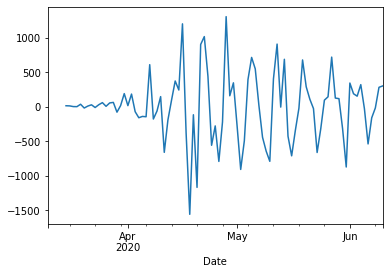

In [41]:
df['Death second difference'].plot()

-----
### 3. Plot the AutoCorrelation(ACF) and Partial Autocorrelation(PACF)
-----

*note: you plot it on the stationary data.*

* plot ACF and PACF

<br>


In time series we use previous data points (lags as we call them) to predict what will happen next. So if we’re just looking at 1 lag, we’ll predict that today will have some weighted correlation to tomorrow (e.g. a regression model could say it’ll be 0.5 greater (the beta value) + an error term). These plots help us determine what are likely to be the most important lags.
<br>

**ACF:** The correlation between the observations at the current point in time and the observations at all previous points in time. We can use ACF to determine the optimal number of MA terms. <br>
* Positive autocorrelation at the first lag: suggests using AR terms<br>
* Negative autocorrelation at the first lag: suggests using MA terms

<br>

**PACF:** As the name implies, PACF is a subset of ACF. PACF expresses the correlation between observations made at two points in time while accounting for any influence from other data points. We can use PACF to determine the optimal number of terms to use in the AR model.

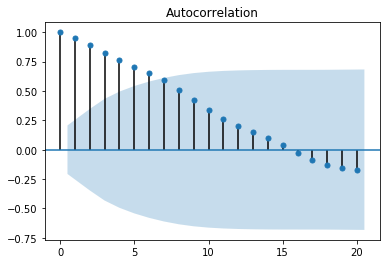

In [42]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

acf_cases = plot_acf(df['cases_4_rolling'].dropna())

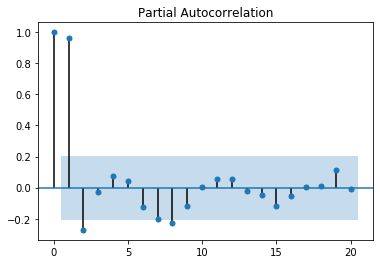

In [43]:
pacf_cases = plot_pacf(df['cases_4_rolling'].dropna())

**Interpretation:** The pacf plot has a sharp drop at lag 2, which suggests that the time series is possibly a AR(2). 


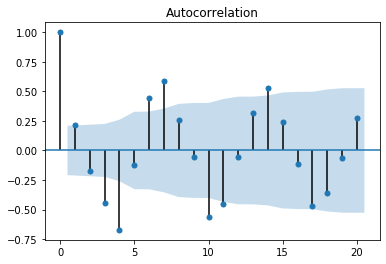

In [44]:
acf_cases = plot_acf(df['Death second difference'].dropna())

**Interpretation:** There is a sharp drop after lag 1, which suggests that MA(1) is the desired simulation model


# Construct the (S)ARIMA Models and Forecast

Finally we can use our ARIMA model now that we have an understanding of our data!

**p,d,q parameters**

* p: The number of lag observations included in the model.
* d: The number of times that the raw observations are differenced, also called the degree of differencing.
* q: The size of the moving average window, also called the order of moving average.

------------
### **First try:** ARIMA trained on 93 time step(Mar 10~ Jun 10) & forecast the last 20 time steps
-----------

In [85]:
# evaluate an ARIMA model for a given order (p,d,q)

## Using root mean quared error metric
def rmse(test, pred):
    return sqrt(mean_squared_error(test, pred))
## Using mean absolute percentage error metric:
def mape(test, pred):
    test, pred = np.array(test), np.array(pred)
    return np.mean(np.abs((test - pred)/test))*100

def arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.8)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    return test, predictions

In [86]:
# evaluate combinations of p, d and q values for an ARIMA model

def GridSearch_arima(dataset, p_values, d_values, q_values):
    '''
    We will choose the arima model that has the lowest RMSE (You can switch to another one if you'd like)
    '''
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = rmse(arima_model(dataset, order)[0], arima_model(dataset, order)[1])
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [78]:
# evaluate parameters

p_values = range(0, 7)
d_values = range(0, 3)
q_values = range(0, 7)

Without cutting out the period when the number of cases were very low.

In [68]:
import warnings
warnings.filterwarnings("ignore")

GridSearch_arima(df['Cases'].values, p_values, d_values, q_values)


Best ARIMA(6, 1, 2) MSE=72176603.825


C:\Users\olivi\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\olivi\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'Forecasting Result using ARIMA on 93 training time steps')

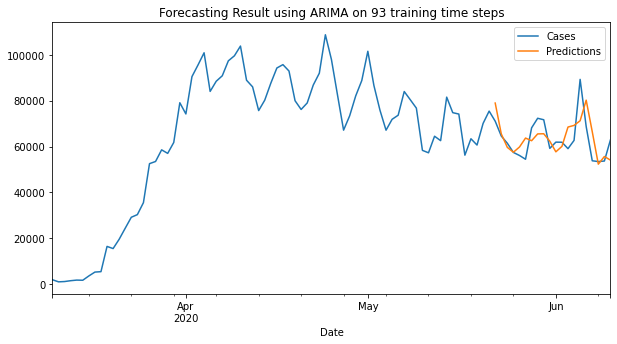

In [88]:
# run the selected model
model = ARIMA(df['Cases'], order=(6,1,2))
results = model.fit(disp=0)
predictions = results.predict(len(df['Cases'])-20, len(df['Cases'])-1, typ = 'levels').rename("Predictions") 

plt.figure(figsize = [10,5])
df['Cases'].plot(legend = True)
predictions.plot(legend = True) 
plt.title('Forecasting Result using ARIMA on 93 training time steps')

In [89]:
# Evaluation
print('RMSE: {}'.format(rmse(df.iloc[-20:]['Cases'],predictions.values)))
print('MAPE: {}'.format(mape(df.iloc[-20:]['Cases'],predictions.values)))

RMSE: 7563.254906600603
MAPE: 9.35045226082227


------
### **2nd try:**  ARIMA trained on 71 time steps( Apr 1 ~ Jun 10) & forecast the last 15 time steps
------

Let's fit only the data after the number of cases reached a significant amount, roughly around April 1st.

In [53]:
ts2 = df[df.index >= '2020-04-01']['Cases']

In [79]:
import warnings
warnings.filterwarnings("ignore")

GridSearch_arima(ts2, p_values, d_values, q_values)

Best ARIMA(6, 1, 0) MSE=79207039.395


C:\Users\olivi\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\olivi\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'Forecasting Result using ARIMA on 71 training time steps')

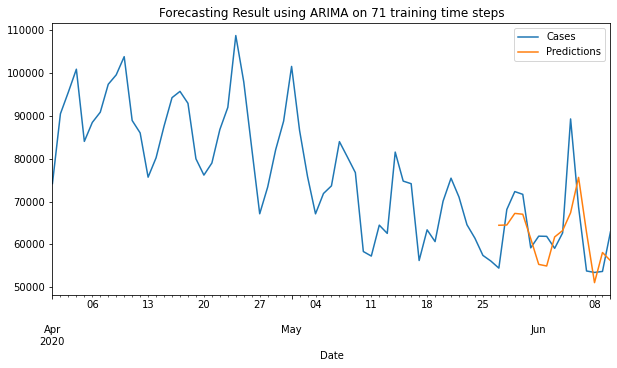

In [90]:
# run the selected model
model = ARIMA(ts2, order=(6,1,0))
results = model.fit(disp=0)
predictions2 = results.predict(len(ts2)-15, len(ts2)-1, typ = 'levels').rename("Predictions") 

plt.figure(figsize = [10,5])
ts2.plot(legend = True)
predictions2.plot(legend = True) 

plt.title('Forecasting Result using ARIMA on 71 training time steps')

In [93]:
# Evaluation
print('RMSE: {}'.format(rmse(ts2.iloc[-15:],predictions2.values)))
print('MAPE: {}'.format(mape(ts2.iloc[-15:],predictions2.values)))

RMSE: 7922.751271767186
MAPE: 9.506739344920717


------
### **3rd try:**  SARIMA trained on 71 time steps( Apr 1 ~ Jun 10) & forecast the last 15 time steps
------

There are some seasonal signals that we discovered earlier, so let's try SARIMA to see if we can get better fit result.

In [12]:
# evaluate an ARIMA model for a given order (p,d,q)
## Using mean quared error metric

def metric(test, pred):
    return mean_squared_error(test, pred)

def sarima_model(X, arima_order, seasonal_order):
    # prepare training dataset
    train_size = int(len(X) * 0.8)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = sm.tsa.statespace.SARIMAX(history, order=arima_order,seasonal_order=seasonal_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    return test, predictions

In [13]:
# evaluate combinations of p, d and q values for an ARIMA model

def GridSearch_sarima(dataset, pdq, s_pdq):
    '''
    We will choose the sarima model that has the lowest RMSE (You can switch to another one if you'd like)
    '''
    dataset = dataset.astype('float32')
    best_score, best_or, best_sor = float("inf"), None, None
    for i in pdq:
        for j in s_pdq:
            order = i
            s_order = j
            try:
                mse = rmse(sarima_model(dataset, order,s_order)[0], sarima_model(dataset, order,s_order)[1])
                if mse < best_score:
                    best_score, best_or, best_sor= mse, order, s_order
            except:
                continue
    print('Best ARIMA%s%s MSE=%.3f' % ( best_or,best_sor, best_score))
    

In [15]:
# evaluate parameters

p_values = range(0, 7)
d_values = range(0, 3)
q_values = range(0, 7)
pdq=list(itertools.product(p_values,d_values,q_values))
s_p = range(0,2)
s_d = range(0,2)
s_q = range(0,2)
s = [1,4,7]
s_pdq=list(itertools.product(s_p,s_d,s_q,s))


Note: The result of this SARIMA Model will be updated soon.

In [ ]:
import warnings
warnings.filterwarnings("ignore")

GridSearch_sarima(ts2, pdq, s_pdq)

In [ ]:
# run the selected model
model = ARIMA(ts2, order=(6,1,0))
results = model.fit(disp=0)
predictions3 = results.predict(len(ts2)-15, len(ts2)-1, typ = 'levels').rename("Predictions") 

plt.figure(figsize = [10,5])
ts2.plot(legend = True)
predictions3.plot(legend = True) 

plt.title('Forecasting Result using ARIMA on 71 training time steps')

In [ ]:
# Evaluation
print('RMSE: {}'.format(rmse(ts2.iloc[-15:],predictions3.values)))
print('MAPE: {}'.format(mape(ts2.iloc[-15:],predictions3.values)))

----------
### To predict the number of cases in the future days
-----------

**Note:** The following data I found is not matching the data on Kaggle, so I will not run it. Once I find the matching data souces I will update this part.

In [45]:
# Get the daily cases of US from sources 
real_data = pd.read_csv('time_series_covid19_confirmed_global.csv')

real_usdata = real_data[(real_data['Country/Region']  == 'US')]
real_usdata = real_usdata.stack().reset_index().drop('level_0',axis = 1).iloc[3:,:].rename(columns = {'level_1': 'Date', 0: 'real_cases'})
real_usdata['Date'] = pd.to_datetime(real_usdata['Date'])
real_usdata = real_usdata.set_index('Date')
real_usdata = real_usdata[real_usdata.index >= '2020-06-10']
real_usdaily = real_usdata - real_usdata.shift(1)

# Create a dataframe that has extended datetime index to store the predicted and real # of cases
from pandas.tseries.offsets import DateOffset
future_dates = [df.index[-1] + DateOffset(days=x) for x in range(0,27) ]
future_dates_df = pd.DataFrame(index=future_dates[1:],columns=df.columns)
future_df = pd.concat([df,future_dates_df])

future_df['pred'] = predictions
future_df['real'] = real_usdaily
future_df.tail(10)

,Cases,Deaths,pred,real
2020-07-02,NaN,NaN,78994.217921,54461
2020-07-03,NaN,NaN,81526.748827,53312
2020-07-04,NaN,NaN,78600.688165,45880
2020-07-05,NaN,NaN,72960.453532,49883
2020-07-06,NaN,NaN,69316.703612,44953
